_Importing Required Libraries_

In [1]:
pip install hampel


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: C:\Users\Anurag Dutta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from matplotlib import pyplot
from numpy import array

## Pretraining

The `horton_intermittency.dat` feeds the model with the dynamics of the Horton Chaotics

In [3]:
data = np.genfromtxt('horton_intermittency.dat')
training_set = pd.DataFrame(data).reset_index(drop=True)
training_set = training_set.iloc[:,1]

## Computing the Gradients

_Calculating the value of_ $\frac{dx}{dt}$, $\frac{d^2x}{dt^2}$, _and_ $\frac{d^3x}{dt^3}$

In [4]:
t_diff = 1
print(training_set.max())
gradient_t = (training_set.diff()/t_diff).iloc[1:] # dx/dt
print(gradient_t)
gradient_tt = (gradient_t.diff()/t_diff).iloc[1:] # d2x/dt2
print(gradient_tt)
gradient_ttt = (gradient_tt.diff()/t_diff).iloc[1:] # d3x/dt3
print(gradient_tt)

1.0
1       -0.000011
2        0.003571
3        0.005754
4        0.006818
5       -0.000807
           ...   
9996    -0.129763
9997    -0.118735
9998    -0.105414
9999    -0.090338
10000   -0.074048
Name: 1, Length: 10000, dtype: float64
2        0.003582
3        0.002183
4        0.001064
5       -0.007625
6       -0.006999
           ...   
9996     0.008219
9997     0.011028
9998     0.013321
9999     0.015076
10000    0.016290
Name: 1, Length: 9999, dtype: float64
2        0.003582
3        0.002183
4        0.001064
5       -0.007625
6       -0.006999
           ...   
9996     0.008219
9997     0.011028
9998     0.013321
9999     0.015076
10000    0.016290
Name: 1, Length: 9999, dtype: float64


## Loading Datasets

In [5]:
data = pd.read_csv("differential-protons-7-day.csv")
training_set = data.iloc[:, 1]
training_set

0       3.013502
1       2.832119
2       2.042342
3       1.794970
4       1.789537
          ...   
2010    0.092451
2011    0.097335
2012    0.105332
2013    0.103997
2014    0.105429
Name: flux, Length: 2015, dtype: float64

In [6]:
test = training_set.tail(30)
test
training_set = training_set.head(1984) # (2013 - 30) + 1
training_set

0       3.013502
1       2.832119
2       2.042342
3       1.794970
4       1.789537
          ...   
1979    0.150448
1980    0.142514
1981    0.136499
1982    0.135064
1983    0.144762
Name: flux, Length: 1984, dtype: float64

In [7]:
training_set = training_set.reset_index(drop=True) # sets a list of integer ranging from 0 to length of training_set as index
gradient_t = gradient_t.reset_index(drop=True) # sets a list of integer ranging from 0 to length of gradient_t as index
gradient_tt = gradient_tt.reset_index(drop=True) # sets a list of integer ranging from 0 to length of gradient_tt as index
gradient_ttt = gradient_ttt.reset_index(drop=True) # sets a list of integer ranging from 0 to length of gradient_ttt as index
print(gradient_t)
print(gradient_tt)
print(gradient_ttt)

0      -0.000011
1       0.003571
2       0.005754
3       0.006818
4      -0.000807
          ...   
9995   -0.129763
9996   -0.118735
9997   -0.105414
9998   -0.090338
9999   -0.074048
Name: 1, Length: 10000, dtype: float64
0       0.003582
1       0.002183
2       0.001064
3      -0.007625
4      -0.006999
          ...   
9994    0.008219
9995    0.011028
9996    0.013321
9997    0.015076
9998    0.016290
Name: 1, Length: 9999, dtype: float64
0      -0.001400
1      -0.001118
2      -0.008690
3       0.000626
4       0.000763
          ...   
9993    0.003290
9994    0.002810
9995    0.002293
9996    0.001755
9997    0.001214
Name: 1, Length: 9998, dtype: float64


In [8]:
df = pd.concat((training_set, gradient_t), axis=1) ##########[:-1]
gradient_tt.columns = ["grad_tt"]
df = pd.concat((df, gradient_tt), axis=1) ################[:-1]
gradient_tt.columns = ["grad_ttt"]
df = pd.concat((df, gradient_ttt), axis=1) ################[:-1]
df.columns = ['y_t', 'grad_t', 'grad_tt', 'grad_ttt']

In [9]:
df # DataFrame

,y_t,grad_t,grad_tt,grad_ttt
0,3.013502,-0.000011,0.003582,-0.001400
1,2.832119,0.003571,0.002183,-0.001118
2,2.042342,0.005754,0.001064,-0.008690
3,1.794970,0.006818,-0.007625,0.000626
4,1.789537,-0.000807,-0.006999,0.000763
...,...,...,...,...
9995,NaN,-0.129763,0.011028,0.002293
9996,NaN,-0.118735,0.013321,0.001755
9997,NaN,-0.105414,0.015076,0.001214
9998,NaN,-0.090338,0.016290,NaN


## Plot of the External Forcing from Chaotic Differential Equation

<Axes: >

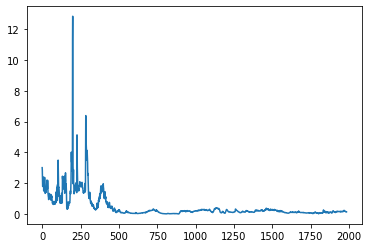

In [10]:
df.iloc[:, 0].plot()

<Axes: >

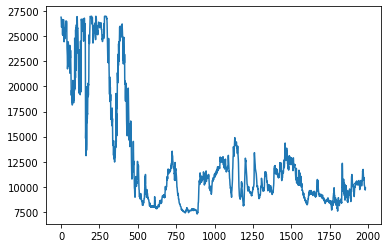

In [11]:
import numpy as np
c1=2.6676
c2=7000
c3=20000
b3=1.06
L = df.iloc[:, 3] + (c1 * df.iloc[:, 1] + b3 * df.iloc[:, 2] + c2 + c3*np.tanh(df.iloc[:,0]))
L.plot()

## Preprocessing the data into supervised learning

In [12]:
# split a sequence into samples
def Supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n_in, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n_out)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
       agg.dropna(inplace=True)
    return agg

In [13]:
data = Supervised(df.values, n_in = 105, n_out = 30)


cols_to_drop = []
for i in range(2, 106):
    cols_to_drop.extend([f'var2(t-{i})', f'var3(t-{i})', f'var4(t-{i})'])

data.drop(cols_to_drop, axis=1, inplace=True)

print(data.head())
print(data.columns)

     var1(t-105)  var1(t-104)  var1(t-103)  var1(t-102)  var1(t-101)  \
105     3.013502     2.832119     2.042342     1.794970     1.789537   
106     2.832119     2.042342     1.794970     1.789537     1.877289   
107     2.042342     1.794970     1.789537     1.877289     1.983688   
108     1.794970     1.789537     1.877289     1.983688     2.153054   
109     1.789537     1.877289     1.983688     2.153054     2.331594   

     var1(t-100)  var1(t-99)  var1(t-98)  var1(t-97)  var1(t-96)  ...  \
105     1.877289    1.983688    2.153054    2.331594    2.405767  ...   
106     1.983688    2.153054    2.331594    2.405767    1.515924  ...   
107     2.153054    2.331594    2.405767    1.515924    2.041262  ...   
108     2.331594    2.405767    1.515924    2.041262    2.062020  ...   
109     2.405767    1.515924    2.041262    2.062020    1.730290  ...   

     var3(t+27)  var4(t+27)  var1(t+28)  var2(t+28)  var3(t+28)  var4(t+28)  \
105    0.006519   -0.004200    2.283268    0.1380

In [14]:
train = np.array(data[0:len(data)-1])
forecast = np.array(data.tail(1))

In [15]:
trainy = train[:,-90:]
trainX = train[:,:-90]

In [16]:
forecasty = forecast[:,-90:]
forecastX = forecast[:,:-90]

In [17]:
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
forecastX = forecastX.reshape((forecastX.shape[0], 1, forecastX.shape[1]))
print(trainX.shape, trainy.shape, forecastX.shape)

(1849, 1, 138) (1849, 90) (1, 1, 138)


In [18]:
c1 = tf.Variable(2.6676, name="c1", trainable=True, dtype=tf.float32)
c2 = tf.Variable(7000, name="c2", trainable=True, dtype=tf.float32)
c3 = tf.Variable(20000, name="c3", trainable=True, dtype=tf.float32)
b3 = tf.Variable(1.06, name="b3", trainable=True, dtype=tf.float32)

splitr = 0.8


def loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true[:, 0] - y_pred[:, 0])
    #squared_difference2 = tf.square(y_true[:, 2]-y_pred[:, 2])
    #squared_difference1 = tf.square(y_true[:, 1]-y_pred[:, 1])
    squared_difference3 = tf.square(
        y_pred[:, 3] + (c1 * y_pred[:, 1] + b3 * y_pred[:, 2] + c2))
    return tf.reduce_mean(squared_difference, axis=-1) + 0.2*tf.reduce_mean(squared_difference3, axis=-1)
model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(30))
model.compile(loss=loss_fn, optimizer='adam')
history = model.fit(trainX[:int(splitr*trainX.shape[0])], trainy[:int(splitr*trainX.shape[0])], epochs=500, batch_size=64, validation_data=(trainX[int(splitr*trainX.shape[0]):trainX.shape[0]], trainy[int(splitr*trainX.shape[0]):trainX.shape[0]]), shuffle=False)

Epoch 1/500
24/24 [==============================] - 8s 63ms/step - loss: 9795680.0000 - val_loss: 9794702.0000
Epoch 2/500
24/24 [==============================] - 0s 8ms/step - loss: 9782955.0000 - val_loss: 9787386.0000
Epoch 3/500
24/24 [==============================] - 0s 7ms/step - loss: 9767539.0000 - val_loss: 9776520.0000
Epoch 4/500
24/24 [==============================] - 0s 8ms/step - loss: 9749038.0000 - val_loss: 9762431.0000
Epoch 5/500
24/24 [==============================] - 0s 8ms/step - loss: 9730146.0000 - val_loss: 9746372.0000
Epoch 6/500
24/24 [==============================] - 0s 10ms/step - loss: 9711975.0000 - val_loss: 9729122.0000
Epoch 7/500
24/24 [==============================] - 0s 10ms/step - loss: 9693965.0000 - val_loss: 9711231.0000
Epoch 8/500
24/24 [==============================] - 0s 8ms/step - loss: 9676257.0000 - val_loss: 9693139.0000
Epoch 9/500
24/24 [==============================] - 0s 8ms/step - loss: 9658966.0000 - val_loss: 9675124.000

In [19]:
forecast_without_mc = forecastX
yhat_without_mc = model.predict(forecast_without_mc) # Step Ahead Prediction
forecast_without_mc = forecast_without_mc.reshape((forecast_without_mc.shape[0], forecast_without_mc.shape[2])) # Historical Input

1/1 [==============================] - 1s 992ms/step


In [20]:
forecastX.shape

(1, 1, 138)

In [21]:
forecast_without_mc.shape

(1, 138)

In [22]:
inv_yhat_without_mc = np.concatenate((forecast_without_mc, yhat_without_mc), axis=1) # Concatenation of predicted values with Historical Data
#inv_yhat_without_mc = scaler.inverse_transform(inv_yhat_without_mc) # Transform labels back to original encoding

In [23]:
inv_yhat_without_mc.shape

(1, 168)

In [24]:
fforecast = inv_yhat_without_mc[:,-90:]

In [25]:
final_forecast = fforecast[:,0:89:3]

In [26]:
# code to replace all negative value with 0
final_forecast[final_forecast<0] = 0

In [27]:
final_forecast

array([[0.18136074, 0.17272779, 0.16611105, 0.16446078, 0.1679724 ,
        0.1747825 , 0.16211247, 0.16987774, 0.16827214, 0.        ,
        0.18338291, 0.00280962, 0.01102827, 0.        , 0.17215103,
        0.00121395, 0.01629014, 0.        , 0.16928862, 0.        ,
        0.        , 0.        , 0.29787114, 0.57145315, 0.        ,
        0.        , 0.        , 0.        , 0.62884921, 0.        ]])

In [28]:
training_set = np.array(training_set)
test = np.array(test)
final_forecast = np.array(final_forecast.squeeze(0))

In [29]:
import math
MSE = np.square(np.subtract(np.array(test),np.array(final_forecast))).mean()   
rsme = math.sqrt(MSE)
print(rsme)  
MAE = np.abs(np.subtract(np.array(test),np.array(final_forecast))).mean()   
mae = MAE
print(mae)

0.15712574004230204
0.11108331199819309
